#### Imports

In [10]:
import cv2
import numpy as np
import open3d as o3d
import os
import matplotlib.pyplot as plt

#### Imports

In [3]:
def save_point_cloud(file_path, point_cloud):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    o3d.io.write_point_cloud(file_path, pcd)

def read_point_cloud(file_path):
    point_cloud = o3d.io.read_point_cloud(file_path)
    return np.asarray(point_cloud.points)

def calculate_depth_map_from_image(image):
    B = image[:, :, 0]
    G = image[:, :, 1]
    R = image[:, :, 2]
    normalized = (G + B * 256 + R * 256 * 256) / (256 * 256 - 1)
    depth_map = normalized * 1000
    return map

def mask_image(image, mask_image):
    image[mask_image == 0] = 0
    return image

def calculate_vertical_fov(image_width, image_height, fov_x):
    aspect_ratio = image_width / image_height
    fov_x_rad = np.radians(fov_x)
    fov_y_rad = 2 * np.arctan(np.tan(fov_x_rad / 2) / aspect_ratio)
    fov_y = np.degrees(fov_y_rad)
    return fov_y

def calculate_focal_length(image_width, fov_x):
    return image_width / (2 * np.tan(np.radians(fov_x) / 2))

def calculate_pixel_focal_length(image_width, image_height, fov_x, fov_y):
    fov_x_rad = np.radians(fov_x)
    fov_y_rad = np.radians(fov_y)
    fx = image_width / (2 * np.tan(fov_x_rad / 2))
    fy = image_height / (2 * np.tan(fov_y_rad / 2))
    cx = image_width / 2.0
    cy = image_height / 2.0
    return fx, fy, cx, cy

def map_to_point_cloud(map, fov_x, fov_y):
    height, width = map.shape
    fx, fy, cx, cy = calculate_pixel_focal_length(width, height, fov_x, fov_y)

    point_cloud = []
    for v in range(height):
        for u in range(width):
            depth = map[v, u]
            if depth <= 0 or depth > 25:  # Skip invalid depth
                continue
            x = (u - cx) / fx
            y = (v - cy) / fy
            xy_depth = np.sqrt(np.square(x) + np.square(y))
            z = np.sqrt(np.square(depth) - np.square(xy_depth))

            point_cloud.append([x, y, z])

    # Convert to Open3D point cloud
    point_cloud_np = np.array(point_cloud)
    return point_cloud_np

In [9]:
def combine_ply_files_with_transformations(directory, output_file):
    combined_points = []
    combined_colors = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.ply'):
            ply_path = os.path.join(directory, filename)
            npy_path = os.path.join(directory, filename.replace('.ply', '.npy'))

            if not os.path.exists(npy_path):
                print(f"Warning: No matching .npy file for {filename}")
                continue

            # Load the PLY file
            ply = o3d.io.read_point_cloud(ply_path)
            points = np.asarray(ply.points)
            colors = np.asarray(ply.colors) if ply.has_colors() else None

            # Load the transformation matrix
            transformation_matrix = np.load(npy_path)

            # Apply the transformation
            points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))
            transformed_points = (transformation_matrix @ points_homogeneous.T).T[:, :3]

            combined_points.append(transformed_points)
            if colors is not None:
                combined_colors.append(colors)

    # Combine all points and colors
    all_points = np.vstack(combined_points)
    if combined_colors:
        all_colors = np.vstack(combined_colors)
    else:
        all_colors = None

    # Create a new PointCloud object for the combined points
    combined_ply = o3d.geometry.PointCloud()
    combined_ply.points = o3d.utility.Vector3dVector(all_points)
    if all_colors is not None:
        combined_ply.colors = o3d.utility.Vector3dVector(all_colors)

    # Write the combined PLY to a file
    o3d.io.write_point_cloud(output_file, combined_ply)
    print(f"Combined PLY file written to {output_file}")

# Example usage
combine_ply_files_with_transformations('generated_data/LIDAR_TOP', 'generated_data/BEV/lidar_combined_point_cloud.ply')


Combined PLY file written to generated_data/BEV/lidar_combined_point_cloud.ply


#### Run post-processing

In [5]:
def clean_up_postprocessed_data(data_dir, string_to_find):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if string_to_find in file:
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Removed: {file_path}")
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

In [6]:
DATA_DIR = "./generated_data"
SEMANTIC_CAM_DIRS = ["SEMANTIC_CAM_FRONT", "SEMANTIC_CAM_FRONT_LEFT", "SEMANTIC_CAM_FRONT_RIGHT", "SEMANTIC_CAM_BACK", "SEMANTIC_CAM_BACK_LEFT", "SEMANTIC_CAM_BACK_RIGHT"]
DEPTH_CAM_DIRS = ["DEPTH_CAM_FRONT", "DEPTH_CAM_FRONT_LEFT", "DEPTH_CAM_FRONT_RIGHT", "DEPTH_CAM_BACK", "DEPTH_CAM_BACK_LEFT", "DEPTH_CAM_BACK_RIGHT"]
fov_w_degrees, fov_h_degrees = 120.0, calculate_vertical_fov(1600, 900, 120)

for (SEM_SUBDIR, DEPTH_SUBDIR) in zip(SEMANTIC_CAM_DIRS, DEPTH_CAM_DIRS):
    directory = f"{DATA_DIR}/{DEPTH_SUBDIR}"
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            timestamp = filename.replace(".png", "")
            depth_image_path = os.path.join(directory, filename)
            image = cv2.imread(depth_image_path)
            depth_map = calculate_depth_map_from_image(image)
            point_cloud = depth_map_to_point_cloud(depth_map, fov_w_degrees, fov_h_degrees)
            save_point_cloud(f"{DATA_DIR}/{DEPTH_SUBDIR}/{timestamp}.pointcloud.ply", point_cloud)
            depth_image_mask = cv2.imread(f"{DATA_DIR}/{SEM_SUBDIR}/{timestamp}.mask.png", cv2.IMREAD_GRAYSCALE)
            masked_depth_image = mask_image(image, depth_image_mask)
            depth_map = calculate_depth_map_from_image(masked_depth_image)
            point_cloud = depth_map_to_point_cloud(depth_map, fov_w_degrees, fov_h_degrees)
            save_point_cloud(f"{DATA_DIR}/{DEPTH_SUBDIR}/{timestamp}.pointcloud.masked.ply", point_cloud)

NameError: name 'depth_map_to_point_cloud' is not defined

In [18]:
def extract_rotation_translation(T):
    # Extract rotation matrix (top-left 3x3 submatrix)
    R = T[:3, :3]
    # Extract translation vector (top-right 3x1 subvector)
    t = T[:3, 3]
    return R, t

def compute_relative_transformation(T_lidar, T_camera):
    # Compute the inverse of the lidar transformation matrix
    T_lidar_inv = np.linalg.inv(T_lidar)
    # Compute the relative transformation from lidar to camera
    T_lidar_to_camera = np.dot(T_camera, T_lidar_inv)
    return T_lidar_to_camera

def transform_points(points, rotation_matrix, translation_vector):
    # Apply rotation and translation to transform points to the camera coordinate system
    transformed_points = np.dot(rotation_matrix, points.T).T + translation_vector
    return transformed_points

def filter_points_by_fov(points, perspective_point, fov_h, fov_v):
    vectors = points - perspective_point
    X = vectors[:, 0]
    Y = vectors[:, 1]
    Z = vectors[:, 2]
    alpha = np.arctan2(Y, X) * 180 / np.pi
    beta = np.arctan2(Z, X) * 180 / np.pi

    mask = (np.abs(alpha) < (fov_h / 2))
    return points[mask], alpha, beta

def visualize_point(point, point_cloud):
    for i in range(-200, 1000, 1):
        x = point[0]
        y = point[1]
        z = point[2]
        point_cloud.append((x+i/10.0, y, z))
        point_cloud.append((x, y+i/10.0, z))
    return np.array(point_cloud)


clean_up_postprocessed_data(DATA_DIR, ".pointcloud.")

DATA_DIR = "./generated_data"
LIDAR_DIR = "LIDAR_TOP"
CAM_DIRS = ["CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT", "CAM_BACK", "CAM_BACK_LEFT", "CAM_BACK_RIGHT"]
fov_h_degrees, fov_v_degrees = 120.0, calculate_vertical_fov(1600, 900, 120)
fov_h, fov_v = fov_h_degrees, fov_v_degrees 

directory = os.path.join(DATA_DIR, LIDAR_DIR)
for filename in os.listdir(directory):
    if filename.endswith('.ply'):
        lidar_ply_file = os.path.join(directory, filename)
        lidar_points = read_point_cloud(lidar_ply_file)
        lidar_npy_file = os.path.join(directory, filename.replace(".ply", ".npy"))
        T_lidar = np.load(lidar_npy_file)

        for CAM_DIR in CAM_DIRS:
            camera_npy_file = os.path.join(DATA_DIR, CAM_DIR, filename.replace(".ply", ".npy"))
            T_camera = np.load(camera_npy_file)
            T_lidar_to_camera = compute_relative_transformation(T_lidar, T_camera)
            R, T = extract_rotation_translation(T_lidar_to_camera)
            transformed_points = transform_points(lidar_points, R, T)
            camera_point = T[:3]
            #transformed_points = visualize_point(camera_point, transformed_points.tolist())
            visible_points, alpha, beta = filter_points_by_fov(transformed_points, camera_point, fov_h, fov_v)
            visible_points_list = visible_points.tolist()            
            visible_points = np.array(visible_points_list)
            visible_points_file_path = os.path.join(DATA_DIR, CAM_DIR, filename.replace(".ply", ".pointcloud.ply"))
            save_point_cloud(visible_points_file_path, visible_points)



Removed: ./generated_data/CAM_BACK/7484670044.pointcloud.ply
Removed: ./generated_data/CAM_BACK/9184670069.pointcloud.ply
Removed: ./generated_data/CAM_BACK/9584670075.pointcloud.ply
Removed: ./generated_data/CAM_BACK/10084670083.pointcloud.ply
Removed: ./generated_data/CAM_BACK/7184670039.pointcloud.ply
Removed: ./generated_data/CAM_BACK/8884670065.pointcloud.ply
Removed: ./generated_data/CAM_BACK/10884670095.pointcloud.ply
Removed: ./generated_data/CAM_BACK/8784670063.pointcloud.ply
Removed: ./generated_data/CAM_BACK/10684670092.pointcloud.ply
Removed: ./generated_data/CAM_BACK/7784670048.pointcloud.ply
Removed: ./generated_data/CAM_BACK/9984670081.pointcloud.ply
Removed: ./generated_data/CAM_BACK/10584670090.pointcloud.ply
Removed: ./generated_data/CAM_BACK/6784670033.pointcloud.ply
Removed: ./generated_data/CAM_BACK/8684670062.pointcloud.ply
Removed: ./generated_data/CAM_BACK/10384670087.pointcloud.ply
Removed: ./generated_data/CAM_BACK/7684670047.pointcloud.ply
Removed: ./generate

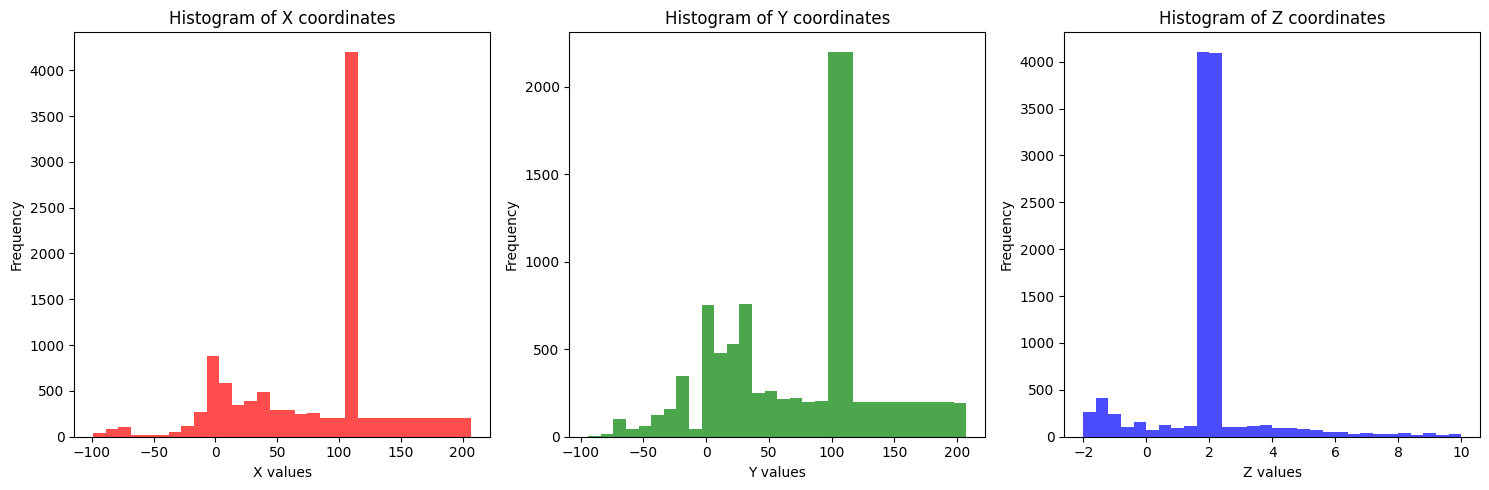

In [74]:
def read_pointcloud_and_create_histograms(ply_file):
    # Read the point cloud from the .ply file
    point_cloud = o3d.io.read_point_cloud(ply_file)
    
    # Extract the coordinate values
    points = point_cloud.points
    x_vals = [point[0] for point in points]
    y_vals = [point[1] for point in points]
    z_vals = [point[2] for point in points]
    
    # Create histograms for x, y, and z coordinates
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(x_vals, bins=30, color='r', alpha=0.7)
    plt.title('Histogram of X coordinates')
    plt.xlabel('X values')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(y_vals, bins=30, color='g', alpha=0.7)
    plt.title('Histogram of Y coordinates')
    plt.xlabel('Y values')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(z_vals, bins=30, color='b', alpha=0.7)
    plt.title('Histogram of Z coordinates')
    plt.xlabel('Z values')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage:
ply_file_path = '/home/leppsalu/Desktop/CARLA/carla-vehicle-simulation/src/generated_data/CAM_FRONT_RIGHT/11084670098.pointcloud.ply'
read_pointcloud_and_create_histograms(ply_file_path)

Text(0, 0.5, 'Frequency')

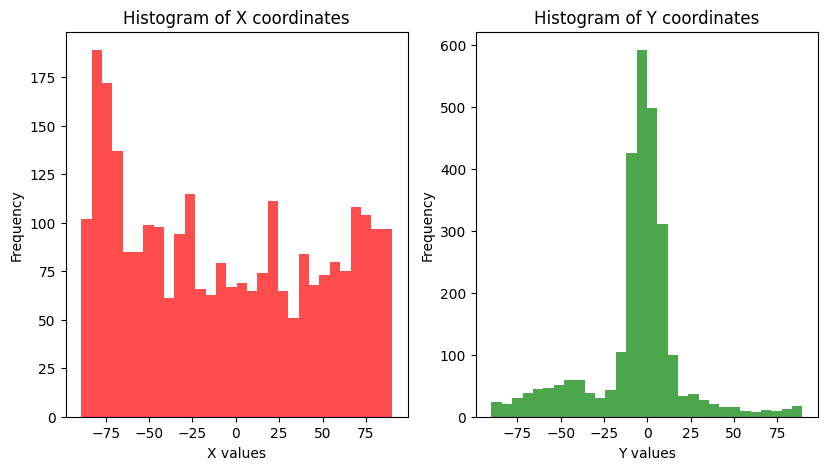

In [11]:
# Create histograms for x, y, and z coordinates
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(alpha, bins=30, color='r', alpha=0.7)
plt.title('Histogram of X coordinates')
plt.xlabel('X values')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(beta, bins=30, color='g', alpha=0.7)
plt.title('Histogram of Y coordinates')
plt.xlabel('Y values')
plt.ylabel('Frequency')